In [30]:
import os
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import comptools as comp

%matplotlib inline

In [2]:
comp_class = True
comp_key = 'MC_comp_class' if comp_class else 'MC_comp'
comp_list = ['light', 'heavy'] if comp_class else ['P', 'He', 'O', 'Fe']

pipeline_str = 'BDT'
pipeline = comp.get_pipeline(pipeline_str)

energybins = comp.analysis.get_energybins()
feature_list, feature_labels = comp.analysis.get_training_features()

df_sim_train, df_sim_test = comp.load_dataframe(datatype='sim',
                                config='IC86.2012', comp_key=comp_key)

Starting out with 108522 sim events
sim quality cut event flow:
      passed_IceTopQualityCuts:    1.0    1.0
FractionContainment_Laputop_InIce:  0.793  0.793
       passed_InIceQualityCuts:  0.795   0.76
                 num_hits_1_60:  0.997  0.759
             reco_energy_range:  0.874  0.662




In [14]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(df_sim_train[feature_list], df_sim_train['target']):
    print(i)
    X_fold = df_sim_train[feature_list].values[train]
    y_fold = df_sim_train['target'].values[train]
    pipeline.fit(X_fold, y_fold)
    probas_ = pipeline.predict_proba(df_sim_train[feature_list].values[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
    

0
1
2
3
4
5
6
7
8
9


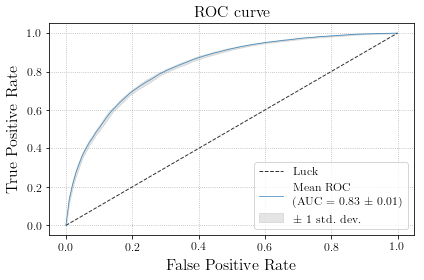

In [36]:
plt.plot([0, 1], [0, 1], linestyle='--', marker='None', lw=1, color='k',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr,
         label=r'Mean ROC'+'\n'+'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         ls='-', lw=0.8, marker='None', alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(fontsize=12)
plt.grid()
outfile = os.path.join(comp.paths.figures_dir,
                'model_evaluation/roc-curve-IC86.2012.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.show()